# First we need to import a number of libraries including our custom functions
There is some overlap in our plotting, but it's nice to be able to both make quick histograms of our data and to have more interactive versions using Bokeh

In [60]:
import importlib
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import os
from textwrap import wrap
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import eli5
import cleanfunc
import re
from sklearn.metrics import r2_score
from bokeh.models import HoverTool
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
importlib.reload(cleanfunc)


<module 'cleanfunc' from 'C:\\Users\\chris\\ABS-Region-Data\\cleanfunc.py'>

We're going to just read in the pre-prepared data. Functions are included in cleanfunc.py to read the raw excel files you can get from the ABS, but this can take significant time to process, so we have exported the cleaned data for use here

In [2]:
df = pd.read_csv('df.csv', index_col = "LABEL")
df.head()


,NUMBER OF BUSINESSES Number of non-employing businesses no.,NUMBER OF BUSINESSES 1-4 employees no.,NUMBER OF BUSINESSES 5-19 employees no.,NUMBER OF BUSINESSES 20 or more employees no.,NUMBER OF BUSINESSES Total number of businesses no.,BUSINESS ENTRIES Number of non-employing business entries no.,BUSINESS ENTRIES 1-4 employees no.,BUSINESS ENTRIES 5-19 employees no.,BUSINESS ENTRIES 20 or more employees no.,BUSINESS ENTRIES Total number of business entries no.,...,RELIGIOUS AFFILIATION Judaism %,RELIGIOUS AFFILIATION Other Religions %,"RELIGIOUS AFFILIATION Secular Beliefs, Other Spiritual Beliefs and No Religious Affiliation %",RELIGIOUS AFFILIATION Inadequately described or not stated %,AUSTRALIAN CITIZENSHIP Australian citizen %,AUSTRALIAN CITIZENSHIP Not an Australian citizen %,AUSTRALIAN CITIZENSHIP Australian Citizenship - Not stated %,SPEAKS A LANGUAGE OTHER THAN ENGLISH AT HOME Proportion of total population %,lat,long
LABEL,,,,,,,,,,,,,,,,,,,,,
Queanbeyan,402.0,193.0,89.0,27.0,712.0,75.0,32.0,5.0,3.855263,111.0,...,0.100000,2.1,28.5,10.5,80.6,11.2,8.2,21.2,-35.352466,149.233725
Wyong,322.0,193.0,85.0,23.0,631.0,40.0,34.0,7.0,3.855263,84.0,...,0.100000,0.7,28.6,9.4,86.1,6.3,7.6,8.2,-33.285641,151.425306
Bathurst,1017.0,574.0,254.0,58.0,1895.0,122.0,80.0,12.0,3.000000,211.0,...,0.100000,0.4,24.0,12.0,86.2,4.0,9.9,4.9,-33.474707,149.641320
Orange,983.0,515.0,270.0,61.0,1832.0,119.0,60.0,10.0,3.855263,196.0,...,0.748598,0.4,22.6,9.7,88.1,3.8,8.0,5.3,-33.329242,149.108147
Maitland,836.0,277.0,114.0,18.0,1241.0,132.0,38.0,8.0,3.855263,172.0,...,0.100000,0.6,26.7,9.8,89.1,3.5,7.4,3.8,-32.708177,151.526844


We're interested in looking at the cycling data. There are a number of different region sizes, so it makes sense to normalise the cyclists by the number of households in an area.

The value we are trying to predict (y) is then this column. We should drop this column from our original dataframe to create X

In [3]:
cycle_col = 'METHOD OF TRAVEL TO WORK - EMPLOYED PERSONS Used one method - Bicycle no.'
residents_col = 'ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  Total no.'
y = df[cycle_col]/df[residents_col]
y.index = df.index
X = df.drop([cycle_col, residents_col], axis = 1)


Let's visually explore our data to see what we're working with

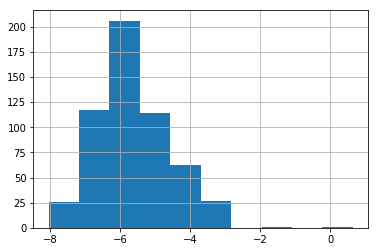

In [4]:
np.log(y).hist()


We have to plot with a log scale because the vast bulk of data is at the low end. There is also a couple of significant outliers at the top that look like they might have to be removed

In [5]:
print(df.loc[y>0.1,[cycle_col, residents_col]])
print("Median population of each region: {}".format(df[residents_col].median()))

                  METHOD OF TRAVEL TO WORK - EMPLOYED PERSONS Used one method - Bicycle no.  \
LABEL                                                                                         
Lord Howe Island                                          54.000000                           
Badgerys Creek                                            44.129032                           

                  ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  Total no.  
LABEL                                                                                         
Lord Howe Island                                              194.0                           
Badgerys Creek                                                 23.0                           
Median population of each region: 6445.0


Both of these outliers have extremely small resident population which when combined with a moderate number of cyclists gives an unusual result. We will drop both these points from our analysis

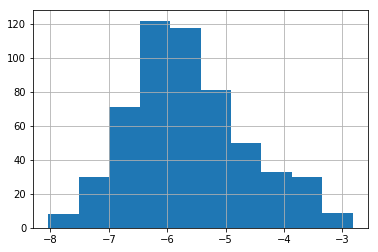

In [6]:
X = X[y<0.1]
y = y[y<0.1]

np.log(y).hist()


That's a little better, though we still have a significant cluster below the 1% mark. We might deal with that later.

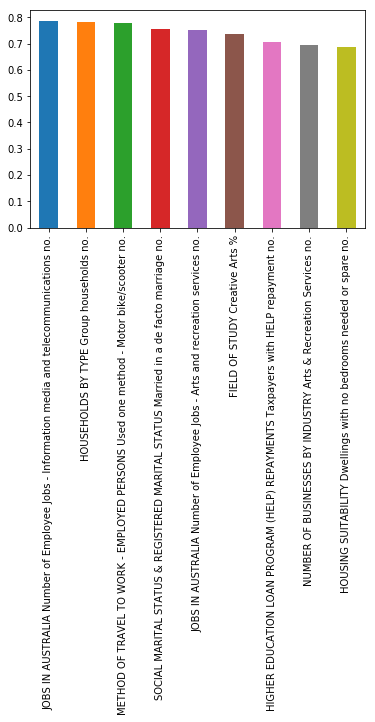

In [22]:
correlations = cleanfunc.sort_series_abs(df.dropna(subset=[cycle_col]
                         ).corr().loc[:,cycle_col])[1:10]

correlations.plot(kind='bar')

JOBS IN AUSTRALIA Number of Employee Jobs - Information media and telecommunications no.    0.786638
HOUSEHOLDS BY TYPE Group households no.                                                     0.783017
METHOD OF TRAVEL TO WORK - EMPLOYED PERSONS Used one method - Motor bike/scooter no.        0.776343
SOCIAL MARITAL STATUS & REGISTERED MARITAL STATUS Married in a de facto marriage no.        0.756083
JOBS IN AUSTRALIA Number of Employee Jobs - Arts and recreation services no.                0.752407
FIELD OF STUDY Creative Arts %                                                              0.737421
HIGHER EDUCATION LOAN PROGRAM (HELP) REPAYMENTS Taxpayers with HELP repayment no.           0.705743
NUMBER OF BUSINESSES BY INDUSTRY Arts & Recreation Services no.                             0.693783
HOUSING SUITABILITY Dwellings with no bedrooms needed or spare no.                          0.687979
Name: METHOD OF TRAVEL TO WORK - EMPLOYED PERSONS Used one method - Bicycle no., dtype: flo

# Machine Learning - First Pass
Now that we have a clean dataframe, we would like to apply some machine learning to it to see if we can predict the number of cyclists. Once we can make predictions, we can interrogate those predictions to see what's going on.

In [7]:
y_binned = np.digitize(y, y.quantile([0, 0.2, 0.4, 0.6, 0.8]))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 43, stratify = y_binned)

In [8]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [9]:

y_pred, y_train_pred = cleanfunc.evaluate_model(rf, X_train, X_test, y_train, y_test)

Loading BokehJS ...

Train data R2 score: 0.9548257094531287
Test data R2 score: 0.4950592337014156


A 50% r2 score on out test data isn't too bad! But the fact that we're getting a 95% R2 score on our train data would suggest that we're over-fitting quite a bit. Let's do some grid-searching to see if we can improve this model

In [23]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'min_samples_split': [2, 5, 10], 'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]}


In [24]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'min_samples_split': [2, 5, 10], 'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [25]:
print(rf_random.best_params_)
best_random = rf_random.best_estimator_


{'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'auto', 'n_estimators': 180}


In [27]:
y_best_pred, y_best_train_pred = cleanfunc.evaluate_model(best_random, X_train, X_test, y_train, y_test)

Loading BokehJS ...

Train data R2 score: 0.9392228189919773
Test data R2 score: 0.5031437700952233


Compared to our old R2 score of 0.50 we have a 2% increase. Not a lot, but it's something! Mousing over the higher values shows that a large number of them are in inner sydney. The bulk of the values are below 2% cyclists. I wonder if the model is being overwhelmed by signal at the high end, meaning it isn't picking up the more subtle signals at the low end. I'm going to recut the dataframe and rebuild our analysis to check.

In [35]:
percentbelow = 2
print('Proportion of data below {}% cyclists in region: {:0.2f}%'.format((percentbelow),100*sum(y_test<(percentbelow/100))/y_test.shape[0]))
print('Test data R2 score for values below {}% cyclists in region: {:0.2f}'.format(percentbelow, r2_score(y_test[y_test<(percentbelow/100)], y_best_pred[y_test<(percentbelow/100)])))


Proportion of data below 2% cyclists in region: 95.50%
Test data R2 score for values below 2% cyclists in region: -0.06


With an R2 value which is negative, we can see that our model is worse than simply taking the average of the data at predicting low end values. Given that this subset holds nearly 85% of all our data, this is definitely something we want to address

In [36]:
y_trunc = y[y<0.02]
X_trunc = X[y<0.02]

We can now reuse our code from earlier to process and graph the data.

In [37]:
y_binned = np.digitize(y_trunc, y_trunc.quantile([0, 0.2, 0.4, 0.6, 0.8]))
X_trunc_train, X_trunc_test, y_trunc_train, y_trunc_test = train_test_split(X_trunc, y_trunc, test_size = 0.2, random_state = 43, stratify = y_binned)

In [38]:
rf_trunc = RandomForestRegressor(n_estimators=200)
rf_trunc.fit(X_trunc_train, y_trunc_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [48]:
y_best_pred, y_best_train_pred = cleanfunc.evaluate_model(rf_trunc, X_trunc_train, X_trunc_test, y_trunc_train, y_trunc_test)

Loading BokehJS ...

Train data R2 score: 0.9054638154170945
Test data R2 score: 0.47164190963970176


Let's look at the correlations in this dataset

In [52]:
perm = eli5.sklearn.PermutationImportance(rf_trunc).fit(X_trunc_test, y_trunc_test)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.0450 ± 0.0252,METHOD OF TRAVEL TO WORK - EMPLOYED PERSONS Used one method - Motor bike/scooter no.
0.0378 ± 0.0165,COMMUTING TO WORK Median commuting distance from Place of Usual Residence kms
0.0321 ± 0.0086,COMMUTING TO WORK Average commuting distance from Place of Usual Residence kms
0.0216 ± 0.0072,FIELD OF STUDY Creative Arts %
0.0143 ± 0.0053,long
0.0086 ± 0.0168,EMPLOYED BY INDUSTRY Arts & Recreation Services %
0.0077 ± 0.0091,"RELIGIOUS AFFILIATION Secular Beliefs, Other Spiritual Beliefs and No Religious Affiliation %"
0.0075 ± 0.0064,SOCIAL MARITAL STATUS & REGISTERED MARITAL STATUS Never Married %
0.0073 ± 0.0041,NUMBER OF BUSINESSES BY INDUSTRY Accommodation & Food Services no.
0.0064 ± 0.0024,SOLAR INSTALLATIONS Increase in SWH installations from previous year %


In [18]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_trunc = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random_trunc.fit(X_trunc_train, y_trunc_train)

NameError: name 'y_best_pred' is not defined

In [ ]:
print(rf_random.best_params_)
best_trunc = rf_random_trunc.best_estimator_
y_best_pred, y_best_train_pred = evaluate_model(best_trunc, X_trunc_train, X_trunc_test, y_trunc_train, y_trunc_test)

In [100]:

lower_bound = 0.004
upper_bound = 0.03

y_trunc = y[(y<upper_bound) & (y > lower_bound)]
X_trunc = X[(y<upper_bound) & (y > lower_bound)]

In [102]:
rf_trunc = RandomForestRegressor(n_estimators=200)
rf_trunc.fit(X_trunc_train, y_trunc_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [103]:
y_low_pred, y_low_train_pred = cleanfunc.evaluate_model(rf_trunc, X_trunc_train, X_trunc_test, y_trunc_train, y_trunc_test)

Loading BokehJS ...

Train data R2 score: 0.9093074136797166
Test data R2 score: 0.567123416812108


Out of curiosity, how does our model trained on truncated data generalize to the full dataset

In [86]:
y_low_pred, y_low_train_pred = cleanfunc.evaluate_model(rf_trunc, X_train, X_test, y_train, y_test)

Loading BokehJS ...

Train data R2 score: 0.41783778976627295
Test data R2 score: 0.47624624049973785


It performs very poorly! It looks like we'll have to Use a multi-layer model, as the effects which dominate at the high end don't have as much of an impact at the low end. 

In [39]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_trunc = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random_trunc.fit(X_trunc_train, y_trunc_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished
C:\Users\chris\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'min_samples_split': [2, 5, 10], 'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200], 'bootstrap': [True, False], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_leaf': [1, 2, 4], 'max_features': ['auto', 'sqrt']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [41]:
print(rf_random_trunc.best_params_)
best_trunc = rf_random_trunc.best_estimator_
y_best_pred, y_best_train_pred = cleanfunc.evaluate_model(best_trunc, X_trunc_train, X_trunc_test, y_trunc_train, y_trunc_test)

{'min_samples_split': 5, 'n_estimators': 100, 'bootstrap': False, 'max_depth': 100, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


Loading BokehJS ...

Train data R2 score: 0.9909904356124214
Test data R2 score: 0.4724753407639539


Interestingly this model seems to have over-fit our train data a little worse, giving us an overall worse R2 score on our holdout set. 

# Combining models
For the final step we're going to try combining a variety of models to maintain accuracy at all levels

In [90]:
y_binned = np.digitize(y, y.quantile([0, 0.2, 0.4, 0.6, 0.8]))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 43, stratify = y_binned)

X_strat = []
forests = []
ranges = [[0,0.02], [0.0, 1]]
for minmax in ranges:
    print(minmax)
    y_trunc = y_train[(y>minmax[0]) & (y<minmax[1])]
    X_trunc = X_train[(y>minmax[0]) & (y<minmax[1])]
    print(y_trunc.shape)
    print(X_trunc.shape)
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_trunc, y_trunc)
    forests.append(rf)
    
print(forests)

[0, 0.02]
(405,)
(405, 453)


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


[0.0, 1]
(441,)
(441, 453)


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


[RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False), RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)]


In [92]:
predictions = pd.DataFrame(data={})
for i, rf in enumerate(forests):
    y_pred = rf.predict(X_test)
    predictions = pd.concat([predictions, pd.DataFrame(y_pred)], axis = 1)
predictions.head()

,0,0
0,0.001296,0.001218
1,0.010521,0.011631
2,0.003219,0.003493
3,0.002351,0.002224
4,0.001464,0.001522


In [96]:
predictions

def chooseprediction(x):
    [low, high] = x
    prediction = high
    if prediction < 0.02:
        prediction = low
    return prediction

def multipredict(forests):
    
    predictions = pd.DataFrame(data={})
    for i, rf in enumerate(forests):
        y_pred = rf.predict(X_test)
        predictions = pd.concat([predictions, pd.DataFrame(y_pred)], axis = 1)
    

        
    prediction = predictions.apply(chooseprediction, axis = 1)
    
    return prediction

y_pred_multi = multipredict(forests)

In [97]:
test_source = ColumnDataSource(data=dict(
    x=y_test,
    y=y_pred_multi,
    desc=y_test.index,
))
hover = HoverTool()

p = figure(plot_width = 600, plot_height = 400, x_axis_label = 'Acutal', y_axis_label = 'Prediction')

p.circle('x', 'y', size=20, color = 'navy', alpha = 0.5, source = test_source, legend = 'Test Data')
p.line([0,max(y_test)],[0, max(y_test)], legend = 'line of perfect fit')
hover.tooltips = [
    ("index", '$index'),
    ("(x,y)", "($x, $y)"),
    ("desc", "@desc"),
]

p.tools.append(hover)
p.legend.location = 'top_left'
p.legend.click_policy="hide"
p.toolbar.logo = None
p.toolbar_location = None
show(p)
print("Test data R2 score: {}".format(r2_score(y_test, y_pred_multi)))


Test data R2 score: 0.5668818502471408
